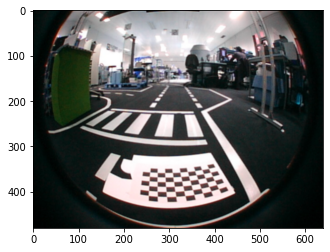

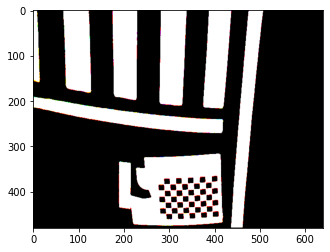

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.linalg import inv

original = cv2.imread('Example.jpg')
cv2.blur(original,(3,3),original,(-1,-1),cv2.BORDER_DEFAULT)

K=np.loadtxt('K_file.txt')
D=np.loadtxt('D_file.txt')


CHECKERBOARD_SIZE = (9,6)
CHECKERBOARD_SIDE_SIZE = 25.4

objpoints = np.empty((0, CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 3), np.float32)
imgpoints = np.empty((0, CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 2), np.float32)

objp = np.zeros((CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 3), np.float32)
objp[:, 0, :2] = CHECKERBOARD_SIDE_SIZE * \
np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)

image_resolution = (640,480)

new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, image_resolution, np.eye(3), balance=1, new_size=image_resolution,fov_scale=0.58)

new_K[0,2]=int(image_resolution[0]/2)
new_K[1,2]=int(image_resolution[1]/2)

map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, image_resolution, cv2.CV_16SC2)
undistorted_img1 = cv2.remap(original, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
K=new_K
D=np.array([[0.0],
            [0.0],
            [0.0],
            [0.0]])

rvec2=np.array([[0.0],
                [0.0],
                [-0.05]])

tvec2=np.array([[-150.0],
                [-400.0],
                [-375.0]])
# HOMOGRAPHY
#ret, corners1 = cv2.findChessboardCorners(undistorted_img1, CHECKERBOARD_SIZE)
#retval, rvec1, tvec1 = cv2.solvePnP(objp, corners1, K, D)


rvec1=np.array([[-0.07720908],
                [ 2.00876977],
                [ 2.33900731]])
tvec1=np.array([[131.98244218],
                [247.33488711],
                [269.95097751]])

R1,jacob1 = cv2.Rodrigues(rvec1)
R2,jacob2=cv2.Rodrigues(rvec2)
R1toR2 = R2 @ R1.transpose()
T1toT2 = R2 @ (-R1.transpose() @ tvec1) + tvec2
normal = np.array([[0.0],
                   [0.0],
                   [1.0]])
normal1 = R1 @ normal
origin = np.zeros((3,1),np.float64)
origin1 = R1 @ origin + tvec1
d_inv =  1.0 / (normal1.transpose() @ origin1)
homography_euclidean = R1toR2 + d_inv * T1toT2 @ normal1.transpose()
homography2 = K @ homography_euclidean @ inv(K)
homography2 = homography2/homography2[2][2]
homography_euclidean = homography_euclidean/homography_euclidean[2][2]

img1_warp = cv2.warpPerspective(undistorted_img1, homography2, image_resolution)
cv2.threshold(img1_warp,150,255,cv2.THRESH_BINARY,img1_warp)
plt.imshow(original)
plt.show()
plt.imshow(img1_warp)
plt.show()